## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

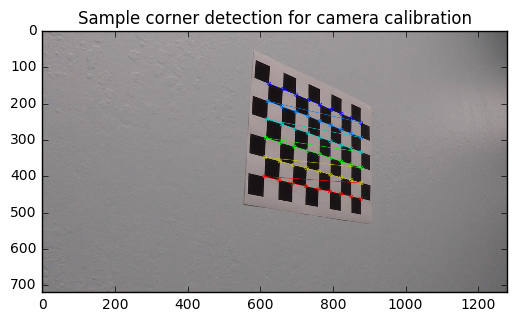

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
    plt.imshow(img)

cv2.destroyAllWindows()

# Draw a sample corner detection
%matplotlib inline
plt.imshow(img)
plt.title('Sample corner detection for camera calibration')
cv2.imwrite("../output_images/01_corner_detection.jpg", img)
plt.show()


# Computing camera calibrtion matrices
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,None)



## Next step is to apply a distortion correction to raw images:

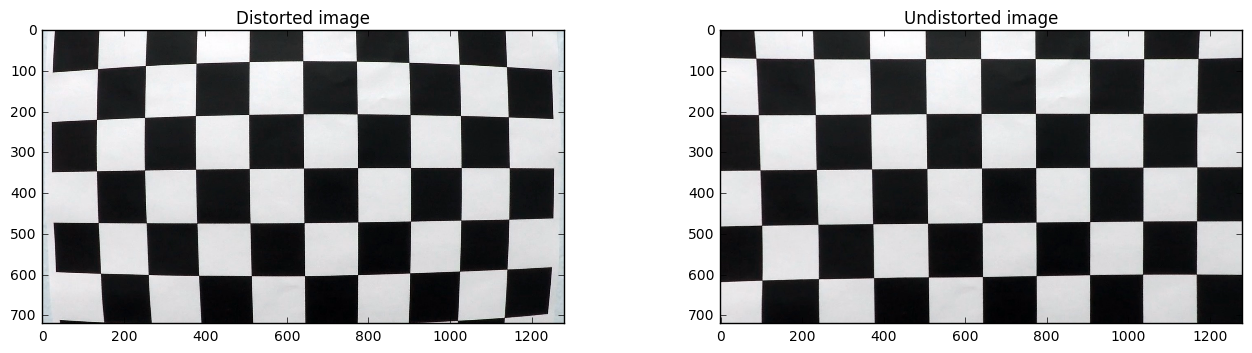

True

In [2]:
# Subplot adjustment
left  = 0.  # the left side of the subplots of the figure
right = 2    # the right side of the subplots of the figure
bottom = 0   # the bottom of the subplots of the figure
top = 1   # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.3
plt.subplots_adjust(left, bottom,   right, top, wspace, hspace)


img = cv2.imread("../camera_cal/calibration1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(1, figsize=(1,2))
plt.subplot(121)
plt.imshow(img)
plt.title("Distorted image")

plt.subplot(122)
plt.imshow(dst)
plt.title("Undistorted image")
plt.show()
cv2.imwrite("../output_images/02_distorted_image.jpg", img)
cv2.imwrite("../output_images/02_undistorted_image.jpg", dst)

## Then I performed the following opertion on each  test image: 
* applied color transformation and gradient operator to create binary images
* applied a perspective transform to rectify binary image ("birds-eye view")
    * I used mouse callback function to get four points (source points) on one of the images and calculate perpective transformation

In [10]:

from collections import deque
      
def image2binary(img, s_thresh=(170, 255), sx_thresh=(30, 255), ksize = 9):
    img = np.copy(img)
    
    # RGB 2 Gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)    
    
    # RGB 2 HLS and separate the S channel
    hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)    
    s_channel = hls[:,:,2]

    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = ksize) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    

    return color_binary
    
# Perspective transformation
###########################################################################

offset = 300
src_points = np.float32([[212, 720], [1100, 720], [722, 477], [558, 477]])
dst_points = np.float32([[offset, 720], [1280 - offset, 720], [1280-offset, 400], [offset, 400]])

M = cv2.getPerspectiveTransform(src_points, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points, src_points)

# Test the perspective transformation
img = cv2.imread("../test_images/straight_lines2.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
warped_img = cv2.warpPerspective(undist_img, M, (undist_img.shape[1], undist_img.shape[0]))


color_binary = image2binary(undist_img)
            
# Combine the two binary thresholds
combined_binary = np.zeros_like(color_binary[:,:,0])
combined_binary[(color_binary[:,:,2] == 1) | (color_binary[:,:,1] == 1)] = 1
    
# Perspective transform
warped_binary_img = cv2.warpPerspective(combined_binary, M, combined_binary.shape[::-1])
_, _, _, _, _, color_warp, histogram, out_img = findLaneLines(warped_binary_img, flag_display =  0)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

# Combine the result with the original image
#undist_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB)
result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(255*color_binary)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
        
        
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image')
ax1.imshow(undist_img)
ax2.set_title('Perspective transformed image')
ax2.imshow(warped_img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.set_title('Transformed binary image')
ax1.imshow(warped_binary_img, cmap='gray')
ax2.set_title('Histogram')
ax2.plot(histogram)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Line detection')
ax1.imshow(out_img, cmap='gray')
ax2.set_title('Final result')
ax2.imshow(result)

    

cv2.imwrite("../output_images/03_original_img.jpg", img)
cv2.imwrite("../output_images/03_transforme_img.jpg", warped_img)
cv2.imwrite("../output_images/04_color_binary.jpg", 255*color_binary)
cv2.imwrite("../output_images/04_thresholded_img.jpg", 255*combined_binary)  
cv2.imwrite("../output_images/04_transformed_binary_img.jpg", 255*warped_binary_img)
cv2.imwrite("../output_images/04_line_detection.jpg", out_img)
cv2.imwrite("../output_images/04_result.jpg", result)




NameError: name 'Line' is not defined

In [7]:
def findLaneLines(warped_img,  nwindows=9, margin=100, minpix=50, flag_display = 1):    
    
    # Histogram (for finding the lane lines)
    histogram = np.sum(warped_img[warped_img.shape[0]/2:,:], axis=0)  
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_img, warped_img, warped_img))*255     
        
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows    
    window_height = np.int(warped_img.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_img.shape[0] - (window+1)*window_height
        win_y_high = warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Implement a moving average filter to smooth things and minimize effect of outliers.
    line_obj.recent_left_fitted.append(left_fit)
    line_obj.recent_right_fitted.append(right_fit)
    
    line_obj.best_left_fit = np.mean(line_obj.recent_left_fitted, axis=0)
    line_obj.best_right_fit = np.mean(line_obj.recent_right_fitted, axis=0)
    
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = line_obj.best_left_fit[0]*ploty**2 + line_obj.best_left_fit[1]*ploty + line_obj.best_left_fit[2]
    right_fitx =  line_obj.best_right_fit [0]*ploty**2 +  line_obj.best_right_fit [1]*ploty +  line_obj.best_right_fit [2]
                
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
     
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    line_obj.radius_of_curvature_left.append(left_curverad)
    line_obj.radius_of_curvature_right.append(right_curverad)
    
    
    #Calculate position of the vehicle in the lane        
    pos = (warped_img.shape[1]/2 - (left_fitx[-1] + right_fitx[-1])/2)*xm_per_pix

       

    # Sanity check
    if abs((right_fitx[0] - left_fitx[0]) - (right_fitx[-1] - left_fitx[-1])) > 400 or abs(left_curverad - right_curverad) > 1000:
        line_obj.detected = False
    else:
        line_obj.detected = True
    
    
    
    # Create an image to draw the lines on the original image
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
 

    if flag_display==1:                    
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        
    return left_fit, right_fit, left_curverad, right_curverad, pos, color_warp, histogram, out_img


def findLaneLinesWithPrevInfo(warped_img, left_fit, right_fit, margin=100, flag_display = 1):
    
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Implement a moving average filter to smooth things and minimize effect of outliers.
    line_obj.recent_left_fitted.append(left_fit)
    line_obj.recent_right_fitted.append(right_fit)
    
    line_obj.best_left_fit = np.mean(line_obj.recent_left_fitted, axis=0)
    line_obj.best_right_fit = np.mean(line_obj.recent_right_fitted, axis=0)
    
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = line_obj.best_left_fit [0]*ploty**2 + line_obj.best_left_fit [1]*ploty + line_obj.best_left_fit [2]
    right_fitx = line_obj.best_right_fit[0]*ploty**2 + line_obj.best_right_fit[1]*ploty + line_obj.best_right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    line_obj.radius_of_curvature_left.append(left_curverad)
    line_obj.radius_of_curvature_right.append(right_curverad)
    
    
    #Calculate position of the vehicle in the lane        
    pos = (warped_img.shape[1]/2 - (left_fitx[-1] + right_fitx[-1])/2)*xm_per_pix

    
    # Sanity check
    if abs((right_fitx[0] - left_fitx[0]) - (right_fitx[-1] - left_fitx[-1])) > 400 or abs(left_curverad - right_curverad) > 1000:
        line_obj.detected = False
    else:
        line_obj.detected = True
        
        
    # Create an image to draw the lines on the original image
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
 

    if flag_display==1:                    
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    
    return left_fit, right_fit, left_curverad, right_curverad, pos, color_warp, histogram, out_img


In [334]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # polynomial coefficients for the last n fits of the line
        self.recent_left_fitted = deque([], HISTORY_LENGTH)
        self.recent_right_fitted = deque([], HISTORY_LENGTH)                
        #polynomial coefficients averaged over the last n iterations
        self.best_left_fit = None  
        self.best_right_fit = None  
        #radius of curvature of the line for the last n iterations in world units
        self.radius_of_curvature_left = deque([], HISTORY_LENGTH)
        self.radius_of_curvature_right = deque([], HISTORY_LENGTH)
        
  


    
def LaneDetection(img):
    
    # undistort images
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    color_binary = image2binary(undist_img, s_thresh, sx_thresh, ksize)
            
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(color_binary[:,:,0])
    combined_binary[(color_binary[:,:,2] == 1) | (color_binary[:,:,1] == 1)] = 1
    
    # Perspective transform
    warped_img = cv2.warpPerspective(combined_binary, M, combined_binary.shape[::-1])
    
    if line_obj.detected == False:        
        left_fit, right_fit, left_curv, right_curv, pos, color_warp, _, _ = findLaneLines(warped_img, nwindows, margin, minpix, flag_display = 0)
    else:
        left_fit, right_fit, left_curv, right_curv, pos, color_warp, _, _ = findLaneLinesWithPrevInfo(warped_img, line_obj.best_left_fit, line_obj.best_right_fit, margin, flag_display = 0)
            
    
    averaged_left_curverad = np.mean(line_obj.radius_of_curvature_left, axis=0)
    averaged_right_curverad = np.mean(line_obj.radius_of_curvature_right, axis=0)


    
    final_curverature = (averaged_left_curverad  + averaged_right_curverad)/2        

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    #undist_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB)
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)

    cv2.putText(result,'Radius of Curvature = ' + str(int(final_curverature)) + ' m', (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result,'Vehicle is ' + str(int(100 * pos)) + ' cm from center', (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
   
    return result
    
from moviepy.editor import VideoFileClip



images = glob.glob('../test_images/test*.jpg')
 
s_thresh=(170, 255)
sx_thresh=(30, 255)
ksize = 9
nwindows = 9               # Choose the number of sliding windows
margin = 100    # Set the width of the windows +/- margin
minpix = 50     # Set minimum number of pixels found to recenter window

HISTORY_LENGTH = 20
line_obj = Line()   # Line class for both left and right lines

"""
for im in images:
    img = cv2.imread(im)
    plt.figure()
    plt.imshow(LaneDetection(img))

"""
video_output = '../output_images/project_video_result2.mp4'
video = VideoFileClip("../project_video.mp4")
fp = video.fl_image(LaneDetection)
fp.write_videofile(video_output, audio=False)

    




OSError: [WinError 6] The handle is invalid

In [59]:
cv2.imshow("img", 255*combined_binary)
cv2.waitKey(30)

-1

In [90]:
cv2.destroyAllWindows()